## Load libs


In [1]:
%config Completer.use_jedi=False

In [395]:
from fastai.vision.all import *
import pandas as pd
from pathlib import Path

import torchvision
import torchvision.transforms as T

from matplotlib import cm
import tqdm
import os

from PIL import Image
import PIL.ImageOps 

from skimage.color import rgba2rgb
from skimage.transform import pyramid_expand, resize, rescale

%reload_ext autoreload
%autoreload 2

## Import data

In [3]:
path = Path('data/nabirds/')

In [4]:
images = pd.read_csv(path/'images.txt', sep=" ", header=None, names=['file','path'])
images['cat_num'] = images['path'].str.split('/').str[0]
images.head()

,file,path,cat_num
0,0000139e-21dc-4d0c-bfe1-4cae3c85c829,0817/0000139e21dc4d0cbfe14cae3c85c829.jpg,0817
1,0000d9fc-4e02-4c06-a0af-a55cfb16b12b,0860/0000d9fc4e024c06a0afa55cfb16b12b.jpg,0860
2,00019306-9d83-4334-b255-a447742edce3,0900/000193069d834334b255a447742edce3.jpg,0900
3,0001afd4-99a1-4a67-b940-d419413e23b3,0645/0001afd499a14a67b940d419413e23b3.jpg,0645
4,000332b8-997c-4540-9647-2f0a8495aecf,0929/000332b8997c454096472f0a8495aecf.jpg,0929


In [5]:
#import classes to get common_names
classes = pd.read_table(path/'classes.txt', delimiter=None)
classes.columns = ['code']
classes[['cat_num','common_name']] = classes['code'].str.split(" ", 1, expand=True)
classes = classes.drop(['code'], axis=1)
classes['cat_num'] = classes['cat_num'].str.zfill(4) #fill missing leading zeros
classes.head()

,cat_num,common_name
0,0001,"Ducks, Geese, and Swans"
1,0002,"Grouse, Quail, and Allies"
2,0003,Loons
3,0004,Grebes
4,0005,Storks


In [6]:
#merge common_name from classes into images df
images = pd.merge(images, classes,  how='left', on='cat_num')
images.head()

,file,path,cat_num,common_name
0,0000139e-21dc-4d0c-bfe1-4cae3c85c829,0817/0000139e21dc4d0cbfe14cae3c85c829.jpg,0817,Oak Titmouse
1,0000d9fc-4e02-4c06-a0af-a55cfb16b12b,0860/0000d9fc4e024c06a0afa55cfb16b12b.jpg,0860,Ovenbird
2,00019306-9d83-4334-b255-a447742edce3,0900/000193069d834334b255a447742edce3.jpg,0900,Savannah Sparrow
3,0001afd4-99a1-4a67-b940-d419413e23b3,0645/0001afd499a14a67b940d419413e23b3.jpg,0645,Eared Grebe (Nonbreeding/juvenile)
4,000332b8-997c-4540-9647-2f0a8495aecf,0929/000332b8997c454096472f0a8495aecf.jpg,0929,Eastern Phoebe


In [7]:
#import train_test_split and merge with images to get the train_test split provided with dataset
split = pd.read_csv(path/'train_test_split.txt', sep=" ", header=None, names=['file','train_test'])
images = pd.merge(images, split,  how='left', on='file')
images.head()

,file,path,cat_num,common_name,train_test
0,0000139e-21dc-4d0c-bfe1-4cae3c85c829,0817/0000139e21dc4d0cbfe14cae3c85c829.jpg,0817,Oak Titmouse,0
1,0000d9fc-4e02-4c06-a0af-a55cfb16b12b,0860/0000d9fc4e024c06a0afa55cfb16b12b.jpg,0860,Ovenbird,0
2,00019306-9d83-4334-b255-a447742edce3,0900/000193069d834334b255a447742edce3.jpg,0900,Savannah Sparrow,0
3,0001afd4-99a1-4a67-b940-d419413e23b3,0645/0001afd499a14a67b940d419413e23b3.jpg,0645,Eared Grebe (Nonbreeding/juvenile),1
4,000332b8-997c-4540-9647-2f0a8495aecf,0929/000332b8997c454096472f0a8495aecf.jpg,0929,Eastern Phoebe,0


## Transforms and data loading

In [8]:
fnames = get_image_files(path/'images')
def label_func(x): 
    return classes[classes['cat_num'] == str(x.parent.name)]['common_name'].item()

In [9]:
tfms = aug_transforms()

In [10]:
dls = ImageDataLoaders.from_path_func(
    path/'images',
    fnames,
    label_func,
    valid_pct=.25,
    bs=32,
    item_tfms=[Resize(384)],
    batch_tfms=[Normalize.from_stats(*imagenet_stats), *tfms]
)

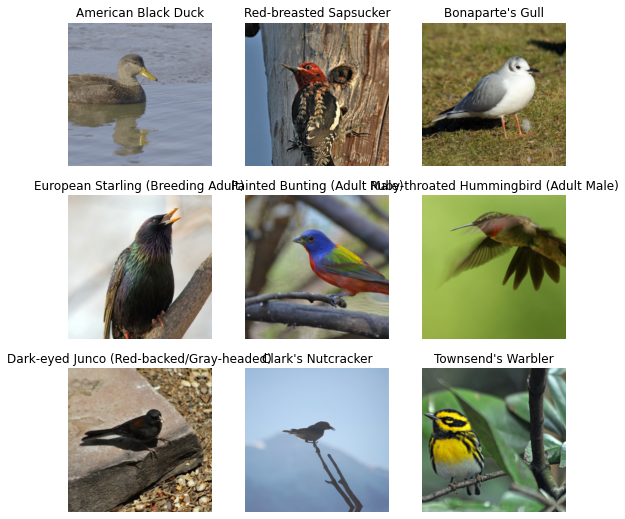

In [11]:
dls.show_batch()

In [12]:
learn = cnn_learner(dls, resnet50, metrics=[accuracy, error_rate], cbs=[MixedPrecision, FP16TestCallback])

In [13]:
# uncomment only after initial training

learn = learn.load('stage-1-short-res50', device="cuda")

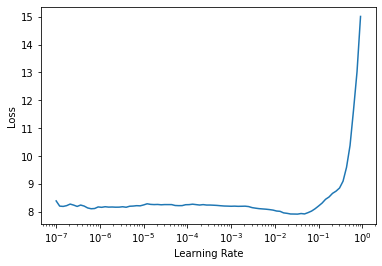

In [22]:
xs = learn.lr_find()

In [23]:
# non 
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.402034,1.551421,0.623888,0.376112,08:16


In [24]:
# run after initial training

# learn.save('stage-1-short-res50')
# learn.export('stage-1-short-res50.pkl')

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=1.2022644114040304e-05)

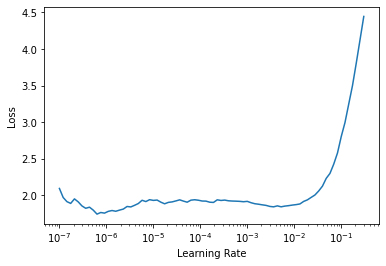

In [17]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(20, slice(5e-5,3e-4))

In [ ]:
learn.save('stage-2-fine-tuned-res50')
learn.export('stage-2-fine-tuned-res50.pkl')

## GradCAM implementation

In [90]:
xb, yb = first(dls.valid)

In [91]:
x = x[10].unsqueeze(0)

In [92]:
class Hook_c():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)   
    def hook_func(self, m, i, o): self.stored = o.detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [93]:
class HookBwd():
    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_func)   
    def hook_func(self, m, gi, go): self.stored = go[0].detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [94]:
cls = 1
with HookBwd(learn.model[0]) as hookg:
    with Hook_c(learn.model[0]) as hook:
        output = learn.model.eval()(x.to('cpu'))
        act = hook.stored
    output[0,cls].backward()
    grad = hookg.stored

In [96]:
torch.argmax(F.softmax(output, dim=-1), dim=1), yb[10]

(tensor([92]), TensorCategory(92, device='cuda:0'))

In [97]:
w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)

<AxesSubplot:>

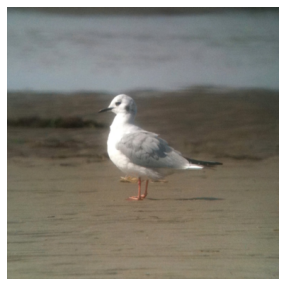

In [110]:
dls.valid.decode((x,))[0][0].show()

In [439]:
dls.vocab[92]

"Bonaparte's Gull"

In [349]:
def show_cam(learn, x, y):
    cls = 1
    x = x.unsqueeze(0)
    with HookBwd(learn.model[0]) as hookg:
        with Hook_c(learn.model[0]) as hook:
            output = learn.model.eval()(x.to('cpu'))
            act = hook.stored
        output[0,cls].backward()
        grad = hookg.stored
    w = grad[0].mean(dim=[1,2], keepdim=True)
    cam_map = (w * act[0]).sum(0)
    x_dec = TensorImage(dls.train.decode((x,))[0][0])
    fig,ax = plt.subplots()
    x_dec.show(ctx=ax)
    ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,384,384,0),
                  interpolation='bilinear', cmap='inferno')
    fig.savefig('test.png', dpi=200)

In [23]:
magma = cm.get_cmap('magma')

In [24]:
xs = cam_map.detach().cpu()

In [25]:
bg = Image.fromarray(x_dec.numpy().transpose(1, 2, 0).astype(np.uint8))

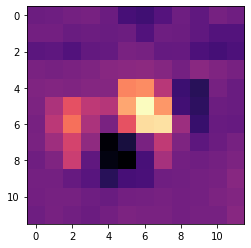

In [28]:
norm = plt.Normalize(vmin=xs.min(), vmax=xs.max())
x_transformed = magma(norm(xs))
plt.imshow(x_transformed)

In [29]:
overlay = Image.fromarray((x_transformed*255).astype(np.uint8), 'RGBA').convert('RGB').resize((384, 384))

In [ ]:
blended = Image.blend(bg, overlay, 0.5)
blended

In [344]:
inferno = plt.cm.inferno

In [437]:
magma = cm.get_cmap('magma')
testb = None
def write_smaps(learn, store_dir=Path('./saliency_maps/'), batch_lim=12):
    global testb
    i = 0 # increments as +batch size
    cls = 1
    
    store_dir.mkdir(exist_ok=True)
    
    for xb, yb in tqdm.notebook.tqdm(learn.dls.valid):
        b, c, h, w = xb.shape
        print(i)
        testb = xb
        for j in tqdm.notebook.tnrange(b):
            x = xb[j].unsqueeze(0)
            with HookBwd(learn.model[0]) as hookg:
                with Hook_c(learn.model[0]) as hook:
                    output = learn.model.eval()(x.to('cpu'))
                    act = hook.stored
                output[0,cls].backward()
                grad = hookg.stored


            w = grad[0].mean(dim=[1,2], keepdim=True)
            cam_map = (w * act[0]).sum(0)
            norm = plt.Normalize(vmin=cam_map.min(), vmax=cam_map.max())
            x_dec = dls.valid.decode((xb,))[0][j]
            x_dec = Image.fromarray(x_dec.numpy().transpose(1, 2, 0).astype(np.uint8))
            overlay = magma(norm(cam_map.detach().cpu()), bytes=True)

            overlay = Image.fromarray(overlay[:, :, :3]).convert('RGB').resize((384, 384), Image.BILINEAR)
            grad_cam = Image.blend(x_dec, overlay, 0.5)
            if grad_cam is None:
                print("###lolololol")
            grad_cam.save(store_dir/f"batch_{i}_{j}.png", 'PNG')
        i += 1
        if i >= batch_lim:
            break
        

In [438]:
write_smaps(learn)

0


KeyboardInterrupt: 

<AxesSubplot:>

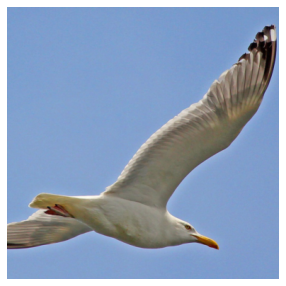

In [291]:
x_dec = dls.train.decode((testb[0],))[0][0]
x_dec.show()

In [269]:
u = iter(learn.dls.valid)

<AxesSubplot:>

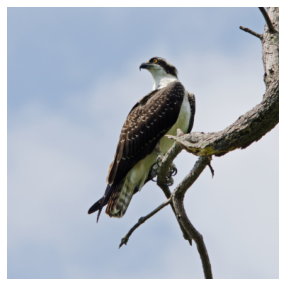

In [270]:
xb, yb = next(u)
x_dec = dls.train.decode((xb[31],))[0][0]
x_dec.show()

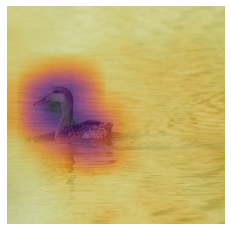

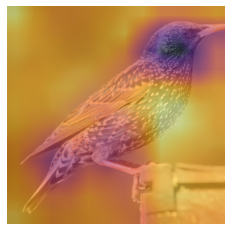

In [430]:
show_cam(learn, testb[31], yb)
show_cam(learn, testb[10], yb)

In [428]:
i = 1
for xb, yb in tqdm.notebook.tqdm(learn.dls.valid):
    b, c, h, w = xb.shape
    testb = xb
    for j in tqdm.notebook.tnrange(b):
        with HookBwd(learn.model[0]) as hookg:
            with Hook_c(learn.model[0]) as hook:
                output = learn.model.eval()(xb[j].unsqueeze(0).to('cpu'))
                act = hook.stored
            output[0,cls].backward()
            grad = hookg.stored
        w = grad[0].mean(dim=[1,2], keepdim=True)
        cam_map = (w * act[0]).sum(0)     
        norm = plt.Normalize(vmin=cam_map.min(), vmax=cam_map.max())
        x_dec = dls.valid.decode((xb,))[0][j]
        x_dec = Image.fromarray(x_dec.numpy().transpose(1, 2, 0).astype(np.uint8))
        overlay = magma(norm(cam_map.detach().cpu()), bytes=True)
        overlay = Image.fromarray((overlay), 'RGBA').convert('RGB').resize((384, 384), Image.BILINEAR)
        grad_cam = Image.blend(x_dec, overlay, 0.5)
    i += 1
    if i >= 3:
        break

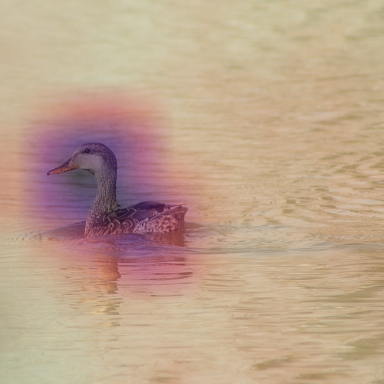

In [429]:
grad_cam

In [433]:
with HookBwd(learn.model[0]) as hookg:
    with Hook_c(learn.model[0]) as hook:
        output = learn.model.eval()(testb[10].unsqueeze(0).to('cpu'))
        act = hook.stored
    output[0,cls].backward()
    grad = hookg.stored


w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)
norm = plt.Normalize(vmin=cam_map.min(), vmax=cam_map.max())
x_dec = dls.valid.decode((testb,))[0][10]
x_dec = Image.fromarray(x_dec.numpy().transpose(1, 2, 0).astype(np.uint8))
overlay = magma(norm(cam_map.detach().cpu()), bytes=True)

overlay = Image.fromarray(overlay[:, :, :3]).convert('RGB').resize((384, 384), Image.BILINEAR)
grad_cam = Image.blend(x_dec, overlay, 0.5)

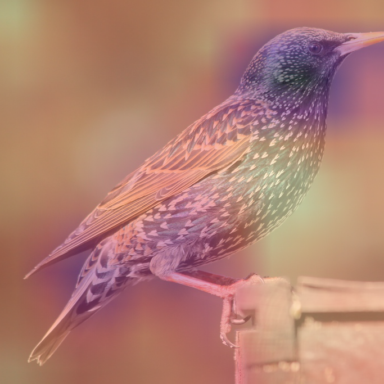

In [434]:
grad_cam